In [1]:
# Import drive and connect
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
# import main modules
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc


In [4]:
# download and import packages for reading .tif files

!pip install pyrsgis
!pip install matplotlib_scalebar
from pyrsgis import raster
from pyrsgis.convert import changeDimension

In [103]:
# constants for program
main_bands = [i+1 for i in range(0,7)]
ndvi_band = 9
labels_band = 8

# choose the input band(s)
# input_bands = ndvi_band
input_bands = main_bands

print('Analyzing bands: ', input_bands)

# store the number of bands, which will be useful for inputting to the neural network later
if input_bands == ndvi_band: nBands = 1
else: nBands = len(main_bands)
print('nBands: ', nBands)

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7


In [104]:
# define functions for use in the notebook - these should be moved to a separate file but making that work with colab is turning out to be a real headache

def removeOuterEdges(x):
    '''Something is off with the top row in the satellite data, and sometimes the other edges, remove them.'''
    if x.ndim == 2: 
        x = np.delete(x, [0, x.shape[0]-1], axis=0) # remove top and bottom edges
        x = np.delete(x, [0, x.shape[1]-1], axis=1) # remove left and right edges
    else: 
        x = np.delete(x, [0, x.shape[1]-1], axis=1) # remove top and bottom edges
        x = np.delete(x, [0, x.shape[2]-1], axis=2) # remove left and right edges

    return x

def normalizeBand(band):
    '''normalize band inputs to 0-1 for input into neural nets'''
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

def normalizeUInt16Band(band):
    '''Bands 1-7 are uint16, ranging from 0-65535, normalize them by dividing by the max.'''
    return band/65535.



In [105]:
# methods related to plotting - should be moved out into a separate file

# define colormap for plots
discrete_cmap = mpl.colors.ListedColormap(["red", "cornflowerblue", "gold", "olivedrab"], name="discrete_cmap")
vmin=-1
vmax=2

def plotNVDIBand(input_data):
    plt.figure(figsize=(24,6))
    plt.imshow(input_data, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

def plotMangroveBand(input_data):
    plt.figure(figsize=(16,6))
    plt.imshow(input_data, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
    # plt.colorbar()
    plt.show()

def plotDifference(labels_data, predicted_data):
    '''
    Plot difference in predicted (or future predicted) mangroves and labeled (past) mangroves.
    # multiply first array by 2 in order to get 4 values for difference plot:
    # pred - label -> output
    # 0 - 0 -> 0, predicted and label/past are not mangroves
    # 1 - 1 -> 1, predicted and label/past are mangroves
    # 1 - 0 -> 2, predicted was mangrove, label/past was not -> growth/false positive
    # 0 - 1 -> 0, predicted was not mangrove, label/past was -> loss/false negative
    '''

    image_difference = 2 * predicted_data - labels_data
    plt.figure(figsize=(24,6))
    plt.imshow(image_difference, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

In [106]:
# methods related to classification evaluation - should be moved out into a separate file

def printClassificationMetrics(y_actual, y_predicted_prob, input_prob=0.5):
    '''Print various classification metrics.'''

    y_predicted = (y_predicted_prob > input_prob).astype(int) # convert prediction probabilities to 0 or 1 values depending on threshold
    cMatrix = confusion_matrix(y_actual, y_predicted)
    pScore = precision_score(y_actual, y_predicted)
    rScore = recall_score(y_actual, y_predicted)
    aScore = accuracy_score(y_actual, y_predicted)
    f1Score = f1_score(y_actual, y_predicted)

    print("Confusion matrix:\n", cMatrix)
    print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))
    print('Accuracy: %.3f' % (aScore))
    print('f1: %.3f' % (f1Score))

    print(classification_report(y_actual, y_predicted))

def makeROCPlot(y_actual, y_predicted_prob):
    fpr, tpr, thresholds = roc_curve(y_actual, y_predicted_prob)
    auc_score = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()


In [107]:
# method for predicting on an image with the trained model
def predictOnImage(model, image):
  '''Take trained model and apply it to a new image.'''
  # read in band data
  ds_features_new, features_new = raster.read(image, bands=input_bands)
  ds_labels_new, labels_new = raster.read(image, bands=labels_band)

  # remove outer edges of data (which sometimes have issues)
  features_new = removeOuterEdges(features_new)
  labels_new = removeOuterEdges(labels_new)

  # fill NaNs with 0s
  features_new = np.nan_to_num(features_new)
  labels_new = np.nan_to_num(labels_new)

  # change label from float to int
  labels_new = (labels_new == 1).astype(int)

  # print('Check shapes:', features_new.shape, labels_new.shape)

  # plot NDVI band (if using it)
  print('\nNDVI band:')
  if input_bands == ndvi_band: plotNVDIBand(features_new)

  # plot Mangrove band
  print('\nLabel mangroves from 2000 data:')
  plotMangroveBand(labels_new)

  # change dimensions of input
  features_new_input = changeDimension(features_new)
  labels_new_input = changeDimension(labels_new)

  # reshape it as an additional step for input into the NN
  features_new_input = features_new_input.reshape((features_new_input.shape[0], 1, nBands))
  # print('Check transformed shapes:', features_new_input.shape, labels_new_input.shape)

  # normalize bands for new image if using the main bands
  if input_bands == main_bands:
    features_new_input = normalizeUInt16Band(features_new_input)

  # predict on new image
  predicted_new_image_prob = model.predict(features_new_input)
  predicted_new_image_prob = predicted_new_image_prob[:,1]

  # print classification metrics
  probThresh = 0.5
  printClassificationMetrics(labels_new_input, predicted_new_image_prob, probThresh)
  makeROCPlot(labels_new_input, predicted_new_image_prob)

  # reshape prediction into 2D for plotting
  predicted_new_image_aboveThresh = (predicted_new_image_prob > probThresh).astype(int)
  prediction_new_image_2d = np.reshape(predicted_new_image_aboveThresh, (ds_labels_new.RasterYSize-2, ds_labels_new.RasterXSize-2)) # need the -2s since I removed the outer edges

  # plot predicted mangroves
  print('\nPredicted mangroves:')
  plotMangroveBand(prediction_new_image_2d)

  # plot difference in predicted and labeled, or future vs past labeled
  print('\nDifference between predicted and labeled mangroves:')
  plotDifference(labels_new, prediction_new_image_2d)


In [108]:
# grab image file
training_image = "/content/drive/MyDrive/MangroveClassification/Images/Florida_1_2000.tif"

In [109]:
# read in band data
ds_features, features = raster.read(training_image, bands=input_bands) # if just inputting one band, do NOT put the single number in a list to pass to "bands", it causes some issue under the hood
ds_labels, labels = raster.read(training_image, bands=labels_band)

# remove outer edges of data (which sometimes have issues)
features = removeOuterEdges(features)
labels = removeOuterEdges(labels)

# fill NaNs with 0s
features = np.nan_to_num(features)
labels = np.nan_to_num(labels)

print('Feature shape: ', features.shape)


Feature shape:  (7, 445, 1855)


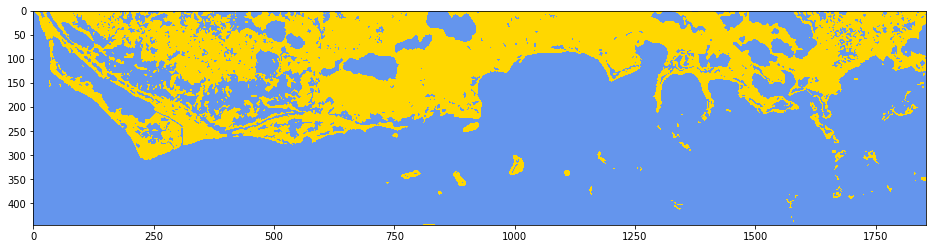

In [110]:
# plot NDVI band
if input_bands == ndvi_band: plotNVDIBand(features)

# plot label (mangrove) band
plotMangroveBand(labels)

In [111]:
# change dimensions for input into neural net
features_input = changeDimension(features)
labels_input = changeDimension(labels)

print(features_input.shape)
print(labels_input.shape)

(825475, 7)
(825475,)


In [112]:
# convert labels to int for classification
labels_input = (labels_input == 1).astype(int)

In [113]:
# check balance of classes
print(f"Class 0: {100 * np.count_nonzero(labels_input==0)/len(labels_input) : .1f}% Class 1: {100 * np.count_nonzero(labels_input==1)/len(labels_input) : .1f}%")

Class 0:  70.2% Class 1:  29.8%


In [114]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(features_input, labels_input, test_size=0.4, random_state=42, stratify=labels_input, shuffle=True)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)


(495285, 7)
(495285,)
(330190, 7)
(330190,)
(495285, 1, 7)
(330190, 1, 7)


In [115]:
# normalize bands - don't really need to do this for the NDVI band, and probably want to use something separate for the other bands, which are already by default bounded
# probably also do not want to normalize differently between the train and test, since their bounds are independent of the samples
# xTrain = normalizeBand(xTrain)
# xTest = normalizeBand(xTest)

# normalize main bands
if input_bands == main_bands:
  xTrain = normalizeUInt16Band(xTrain)
  xTest = normalizeUInt16Band(xTest)

In [116]:
# Define the parameters of the model
if input_bands == ndvi_band:
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      # keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])
else:
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    # keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary)

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f2a3a2789d0>>


In [117]:
# fit the model
history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=3)

Epoch 1/3
10835/10835 [==============================] - 17s 2ms/step - loss: 0.3201 - accuracy: 0.8572 - val_loss: 0.1089 - val_accuracy: 0.9579
Epoch 2/3
10835/10835 [==============================] - 16s 1ms/step - loss: 0.1067 - accuracy: 0.9591 - val_loss: 0.1031 - val_accuracy: 0.9610
Epoch 3/3
10835/10835 [==============================] - 17s 2ms/step - loss: 0.1033 - accuracy: 0.9604 - val_loss: 0.1025 - val_accuracy: 0.9610


In [118]:
print(history.history)

# could make some plots of the metrics/conversion - would want to plot the f1 score though instead of accuracy
# fig, ax = plt.subplots()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# epochs = range(len(mae))

# ax.plot(epochs, mae, label='Train MAE')
# ax.plot(epochs, val_mae, label='Val MAE')

# ax.legend();

{'loss': [0.19180837273597717, 0.10522255301475525, 0.10341975837945938], 'accuracy': [0.9230860471725464, 0.9597951173782349, 0.9603748321533203], 'val_loss': [0.10885200649499893, 0.10306044667959213, 0.1024966835975647], 'val_accuracy': [0.9579435586929321, 0.9609519243240356, 0.9609922766685486]}


Confusion matrix:
 [[223823   8131]
 [  4742  93494]]

P-Score: 0.920, R-Score: 0.952
Accuracy: 0.961
f1: 0.936
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    231954
           1       0.92      0.95      0.94     98236

    accuracy                           0.96    330190
   macro avg       0.95      0.96      0.95    330190
weighted avg       0.96      0.96      0.96    330190



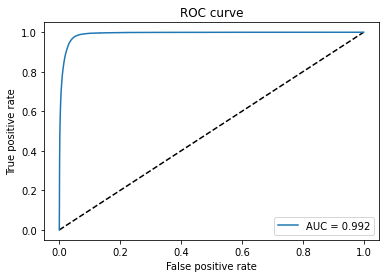

In [119]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

printClassificationMetrics(yTest, yTest_pred_prob)
makeROCPlot(yTest, yTest_pred_prob)


NDVI band:

Label mangroves from 2000 data:


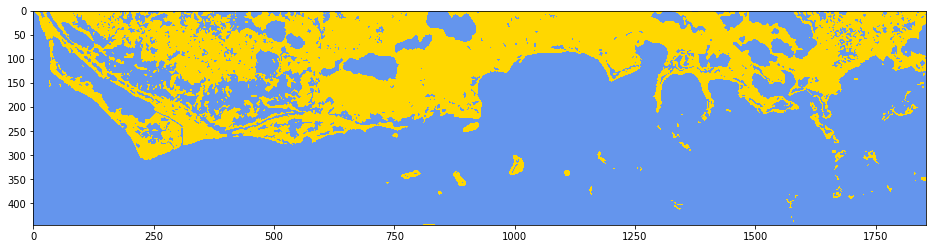

Confusion matrix:
 [[551780  28106]
 [ 69230 176359]]

P-Score: 0.863, R-Score: 0.718
Accuracy: 0.882
f1: 0.784
              precision    recall  f1-score   support

           0       0.89      0.95      0.92    579886
           1       0.86      0.72      0.78    245589

    accuracy                           0.88    825475
   macro avg       0.88      0.83      0.85    825475
weighted avg       0.88      0.88      0.88    825475



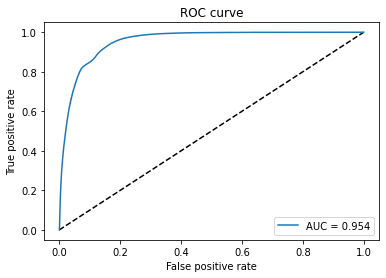


Predicted mangroves:


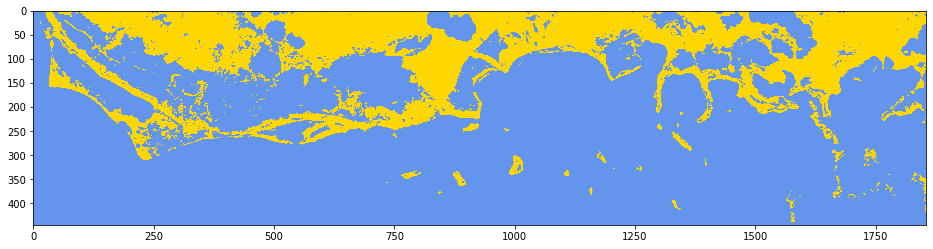


Difference between predicted and labeled mangroves:


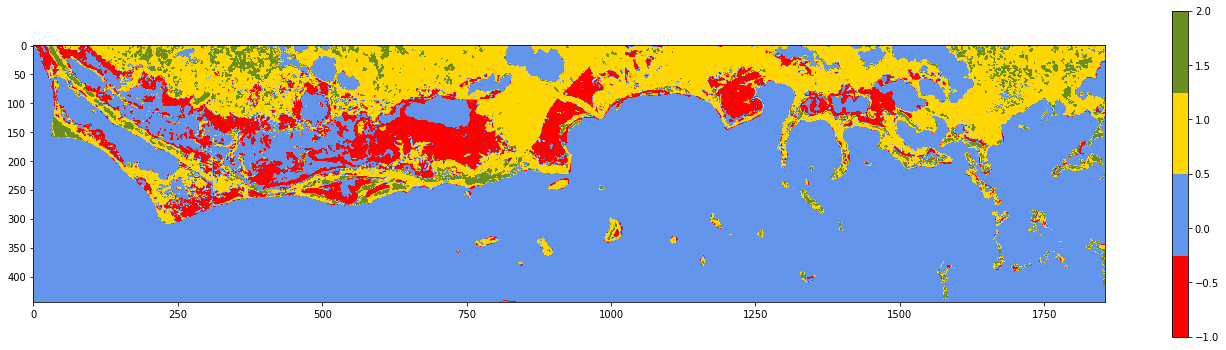

In [123]:
# apply model to new images
predictOnImage(model, "/content/drive/MyDrive/MangroveClassification/Images/Florida_1_2020.tif")
# predictOnImage(model, "/content/drive/MyDrive/MangroveClassification/Images/Florida_3_2000.tif")
# predictOnImage(model, "/content/drive/MyDrive/MangroveClassification/Images/Florida_3_2020.tif")
